#**Binary Classification for the failing period**#

Here, we're gonna use multiple binary classification algorithms  to predict which engines will fail in the current period, e.g.
remaining cycles or TTF in the range 0-30 cycles. Evaluated algorithms include :

- Logistic Regression: is the classification counterpart to linear regression. Predictions are mapped to be
between 0 and 1 through the logistic function, which means that predictions can be interpreted as class
probabilities.
- Support Vector Machines (SVM): use a mechanism called kernels, which essentially calculate distance between
two observations. The SVM algorithm then finds a decision boundary that maximizes the distance between the
closest members of separate classes.
-K Nearest Neighbors: are instance-based algorithms, which mean that they save each training observation. They
then make predictions for new observations by searching for the most similar training observations and
pooling their values.
- Gaussian Naive Bayes : is an algorithm based around conditional probability and counting. Essentially,
the model is actually a probability table that gets updated through the training data. To predict a new
observation, the model simply look-up the class probabilities in the probability table based on its feature
values.
- Random Forest

Here, the performance of these models will be evaluated on the
test dataset, and again we're gonna use the original features and the modified ones.

Metrics used are AUC ,ROC, Recall, Precision, F1 Score, and Accuracy, but we're gonna give more importance to AUC and ROC because the data is imbalanced as we've seen in the Data Preparation.

Let's begin by importing the libraries needed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

Let's load the Data.

In [2]:
d_train = pd.read_csv('sample_data/train.csv')
d_train.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,sd12,sd13,sd14,sd15,sd17,sd20,sd21,TTF,BNC,MCC
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,191,0,0
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,...,0.438406,0.035355,5.041671,0.008697,0.000000,0.042426,0.003253,190,0,0
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,...,0.404475,0.026458,3.717450,0.007640,1.154701,0.055076,0.044573,189,0,0
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,...,0.495950,0.029439,3.050906,0.028117,1.000000,0.076322,0.037977,188,0,0
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,...,0.432574,0.025884,2.651326,0.025953,1.095445,0.073621,0.033498,187,0,0


In [3]:
d_test = pd.read_csv('sample_data/test.csv')
d_test.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,sd12,sd13,sd14,sd15,sd17,sd20,sd21,TTF,BNC,MCC
0,1,31,-0.0006,0.0004,642.58,1581.22,1398.91,21.61,554.42,2388.08,...,0.261591,0.028810,3.302941,0.021174,0.707107,0.124016,0.025037,112,0,0
1,2,49,0.0018,-0.0001,642.55,1586.59,1410.83,21.61,553.52,2388.10,...,0.450255,0.008367,1.370062,0.011429,1.095445,0.069785,0.027820,98,0,0
2,3,126,-0.0016,0.0004,642.88,1589.75,1418.89,21.61,552.59,2388.16,...,0.418234,0.029665,2.979090,0.030924,0.836660,0.143631,0.018966,69,0,0
3,4,106,0.0012,0.0004,642.78,1594.53,1406.88,21.61,552.64,2388.13,...,0.363291,0.027019,0.622953,0.021249,1.341641,0.126372,0.021106,82,0,0
4,5,98,-0.0013,-0.0004,642.27,1589.94,1419.36,21.61,553.29,2388.10,...,0.260231,0.023022,1.923609,0.009627,0.547723,0.091924,0.101100,91,0,0


In [4]:
print(d_train['BNC'].value_counts())
print('\nNegaitve samples =  {0:.0%}'.format(d_train['BNC'].value_counts()[0]/d_train['BNC'].count()))
print('\nPosiitve samples =  {0:.0%}'.format(d_train['BNC'].value_counts()[1]/d_train['BNC'].count()))

0    17531
1     3100
Name: BNC, dtype: int64

Negaitve samples =  85%

Posiitve samples =  15%


As we see again, the data is imbalanced.

Let's create the training features just like we did with Regression.

In [5]:
original_features=['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']

features_added= ['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7',
       's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21',
       'av2', 'av3', 'av4', 'av6', 'av7', 'av8', 'av9', 'av11', 'av12', 'av13',
       'av14', 'av15', 'av17', 'av20', 'av21', 'sd2', 'sd3', 'sd4', 'sd6',
       'sd7', 'sd8', 'sd9', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd17',
       'sd20', 'sd21']

features_highcorrel=['av21','av20','av12','av7','s12','s7','s21','s20']

features=original_features

y_train = d_train['BNC']
y_test = d_test['BNC']

if y_train.isnull().any():

        y_train = y_train.dropna()

The variable features contains for now the original features. We're gonna change it later to train on the other features.

As we know, our classifiers have hyperparameters that we can't randomly choose to get a good performance. So our method is to perform Grid Search hyper parameter tuning on a classifier, to find the best hyperparameters, then we're gonna evaluate. And this is gonna be done for each and every classifier.

Let's create a function that helps us do hyperparameter tuning since we're gonna repeat this for each and every model. It takes as arguments:
- model: The model name identifier
- clf : The classifier to be tuned
- params: Grid Search parameters
- score : Grid Search score
And it returns the best parameters and the predictions.

In [6]:
def tuning(model, clf, features, params, score, y_train):

    X_train = d_train[features]

    X_train = X_train.loc[y_train.index]

    X_test = d_test[features]

    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)

    if hasattr(grid_search, 'predict_proba'):
        y_score = grid_search.predict_proba(X_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred

    predictions = {'y_pred' : y_pred, 'y_score' : y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)

    return grid_search.best_estimator_, df_predictions

#**A.Training on original features**#

##**A.1. Logistic Regression**##

Logistic Regression is a statistical method used for binary classification problems. It predicts the probability that a given input belongs to a certain class. The output is a value between 0 and 1, which is typically interpreted as the probability of the input belonging to the positive class. Logistic Regression models the relationship between a set of independent variables (features) and a dependent variable (target) by applying a logistic function.

Key hyperparameters in Logistic Regression include:

1. **Learning Rate**: This controls how much the model is adjusted during training. A too high learning rate can cause the model to converge too quickly to a suboptimal solution, while a too low learning rate can make the training process very slow.

2. **Regularization**: Regularization methods like L1 (Lasso), L2 (Ridge), or Elastic Net regularization are used to prevent overfitting by penalizing large coefficients. L1 regularization tends to produce sparse models (some coefficients become zero), while L2 regularization makes coefficients smaller but does not set them to zero.

3. **Solver**: This is the algorithm used for optimization. Common solvers include 'liblinear', 'sag', 'saga', and 'lbfgs'. Different solvers can be more efficient for different types of data.

4. **Maximum Iterations**: This is the maximum number of iterations taken for the solvers to converge.

5. **C (Inverse of Regularization Strength)**: This hyperparameter controls the degree of regularization (smaller values specify stronger regularization). It is important to balance this to avoid overfitting or underfitting.

6. **Class Weight**: This parameter is used to adjust the weight given to each class. It’s useful in cases where classes are imbalanced.

7. **Penalty**: This specifies the norm used in the penalization (commonly 'l2' for logistic regression).

In our case, we're interested by the two hyperparameters Solver and C.

The random_state, on the other hand, is a parameter used for initializing the internal random number generator, which affects elements like the shuffling of the data or the initialization of the weights. Its primary purpose is to ensure reproducibility of results rather than to control the model's learning behavior.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
model = 'Logistic Regression B'
clf_lgr = LogisticRegression(random_state=123)
gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'
clf_lgr = make_pipeline(StandardScaler(), LogisticRegression(random_state=123, max_iter=1000))
clf_lgr = make_pipeline(StandardScaler(), LogisticRegression(random_state=123, max_iter=1000))
gs_params = {'logisticregression__C': [.01, 0.1, 1.0, 10], 'logisticregression__solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'

Bestparam, pred_lgr = tuning(model, clf_lgr, params=gs_params, score=gs_score,features=features, y_train=y_train)
print('\nBest Parameters:\n', Bestparam)


Best Parameters:
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=123))])


Now as we found the best parameters, let's evaluate.

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score, f1_score


y_pred = Bestparam.predict(d_test[features])

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Calculating Metrics
roc_auc_lr = roc_auc_score(y_test, Bestparam.predict_proba(d_test[features])[:, 1])
recall_lr= recall_score(y_test, y_pred)
accuracy_lr = accuracy_score(y_test, y_pred)
precision_lr= precision_score(y_test, y_pred)
f1_lr= f1_score(y_test, y_pred)

# Print the metrics
print("\nMetrics:")
print("ROC AUC:", roc_auc_lr)
print("Recall:", recall_lr)
print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("F1 Score:", f1_lr)


Confusion Matrix:
 [[74  1]
 [ 8 17]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94        75
           1       0.94      0.68      0.79        25

    accuracy                           0.91       100
   macro avg       0.92      0.83      0.87       100
weighted avg       0.91      0.91      0.90       100


Metrics:
ROC AUC: 0.9792
Recall: 0.68
Accuracy: 0.91
Precision: 0.9444444444444444
F1 Score: 0.7906976744186047


Now let's plot:
- Plot: AUC ROC
- Plot: Precision-Recall curve
- Plot: Precision-Recall threshold, also show the number of engines predicted for maintenace per period
- Plot: TPR-FPR threshold ( True Positive rate vs False Positive rate)
        

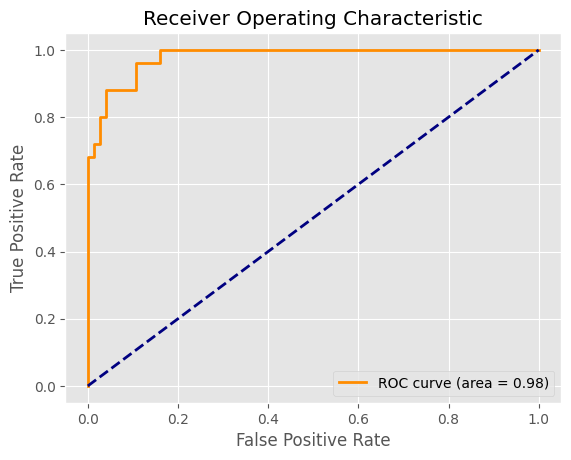

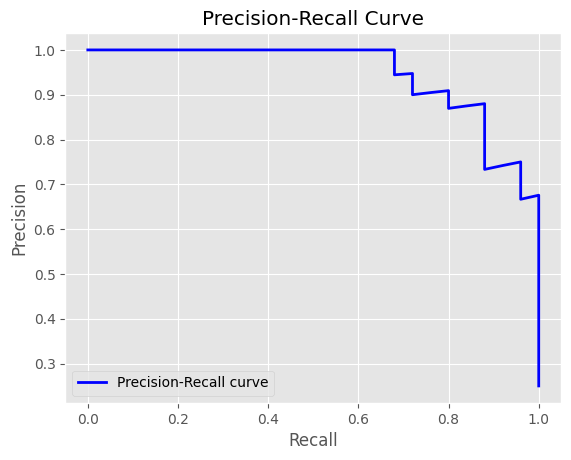

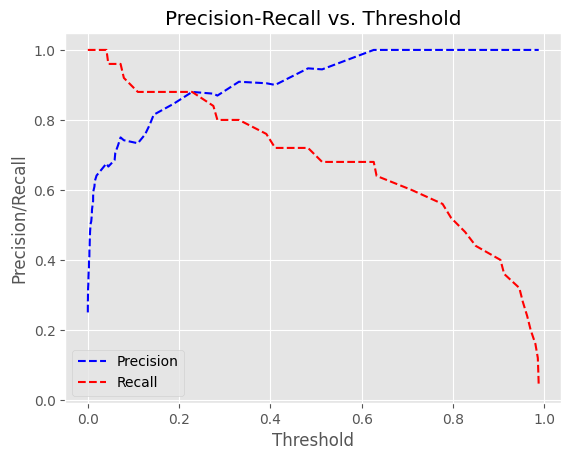

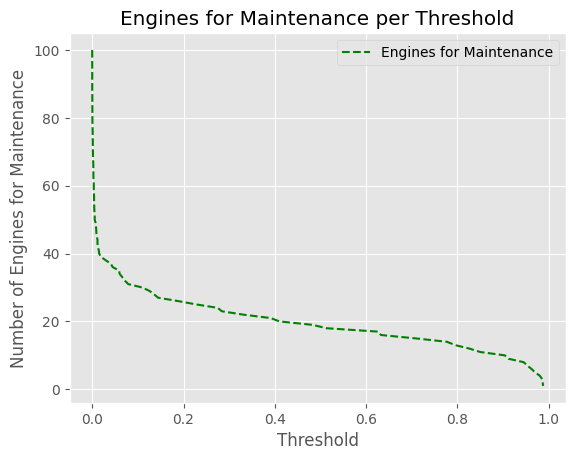

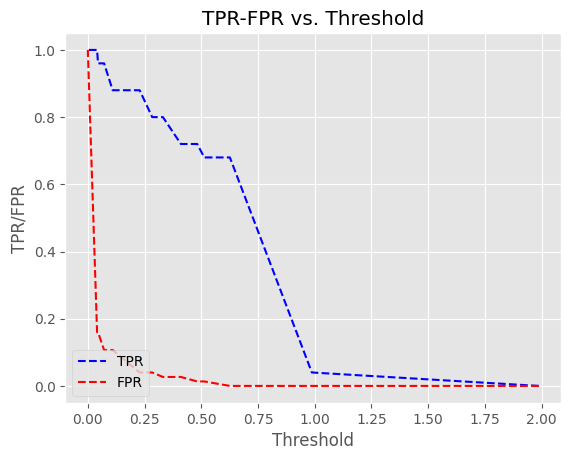

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score

X_test=d_test[features]
# Calculate probabilities
y_scores = Bestparam.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Precision-Recall vs. Threshold
plt.figure()
plt.plot(thresholds_pr, precision[:-1], "b--", label="Precision")
plt.plot(thresholds_pr, recall[:-1], "r--", label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall vs. Threshold')
plt.legend(loc="lower left")
plt.show()

# Number of engines predicted for maintenance per period
maintenance_count = [sum(y_scores >= t) for t in thresholds_pr]

plt.figure()
plt.plot(thresholds_pr, maintenance_count, "g--", label="Engines for Maintenance")
plt.xlabel('Threshold')
plt.ylabel('Number of Engines for Maintenance')
plt.title('Engines for Maintenance per Threshold')
plt.legend(loc="upper right")
plt.show()

# TPR-FPR vs. Threshold
plt.figure()
plt.plot(thresholds_roc, tpr, "b--", label="TPR")
plt.plot(thresholds_roc, fpr, "r--", label="FPR")
plt.xlabel('Threshold')
plt.ylabel('TPR/FPR')
plt.title('TPR-FPR vs. Threshold')
plt.legend(loc="lower left")
plt.show()


Engines in the above charts represent the number of engines to be maintain per period, the maintenance capacity.

##**A.2 Decision Tree**##

Just as the Logistic regression, we're gonna tune and then evaluate.

In [10]:
model = 'Decision Tree'
clf_dt = DecisionTreeClassifier(random_state=123)

dt_params = {
    'max_depth': [2, 3, 4, 5, 6], 'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gs_score = 'roc_auc'

# Perform grid search
Bestparam_dt, pred_dt = tuning(model, clf_dt, params=dt_params, score=gs_score, features=features, y_train=y_train)
print('\nBest Parameters for Decision Tree:\n', Bestparam_dt)



Best Parameters for Decision Tree:
 DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4,
                       random_state=123)


In [38]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score, f1_score

y_pred = Bestparam_dt.predict(d_test[features])

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

roc_auc_dt = roc_auc_score(y_test, Bestparam_dt.predict_proba(d_test[features])[:, 1])
recall_dt= recall_score(y_test, y_pred)
accuracy_dt = accuracy_score(y_test, y_pred)
precision_dt = precision_score(y_test, y_pred)
f1_dt= f1_score(y_test, y_pred)

print("\nMetrics:")
print("ROC AUC:", roc_auc_dt)
print("Recall:", recall_dt)
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("F1 Score:", f1_dt)


Confusion Matrix:
 [[74  1]
 [11 14]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.93        75
           1       0.93      0.56      0.70        25

    accuracy                           0.88       100
   macro avg       0.90      0.77      0.81       100
weighted avg       0.89      0.88      0.87       100


Metrics:
ROC AUC: 0.9445333333333333
Recall: 0.56
Accuracy: 0.88
Precision: 0.9333333333333333
F1 Score: 0.7000000000000001


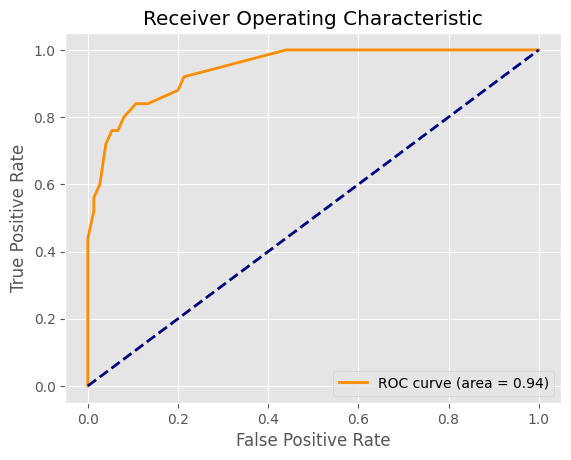

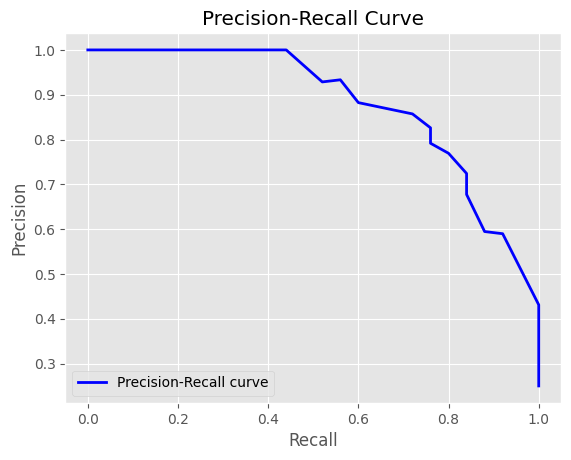

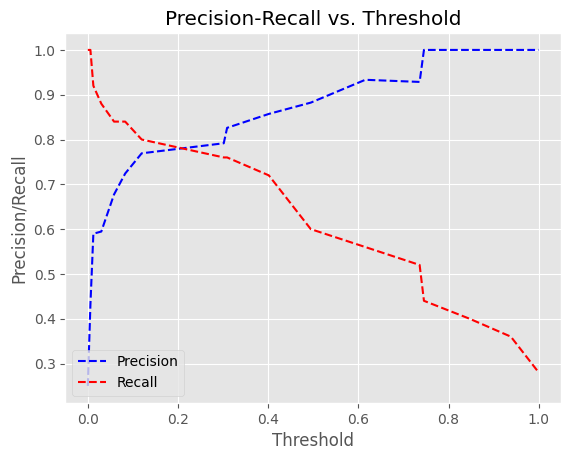

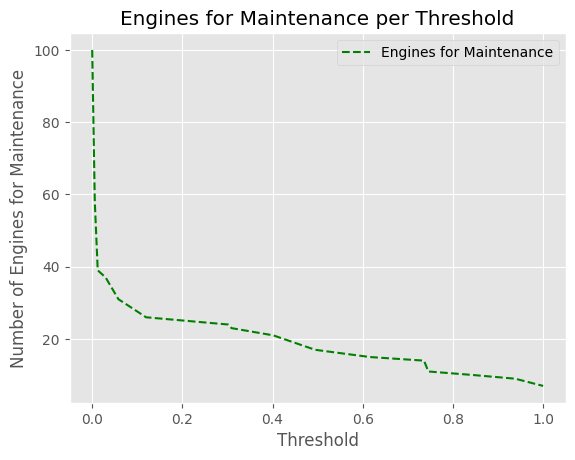

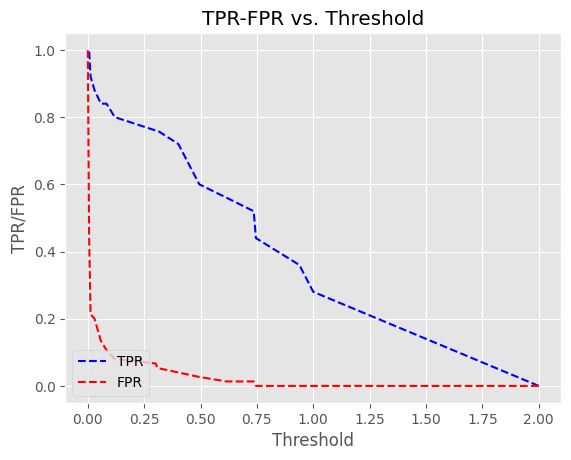

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Calculate probabilities for the positive class
y_scores = Bestparam_dt.predict_proba(d_test[features])[:, 1]

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Precision-Recall vs. Threshold
plt.figure()
plt.plot(thresholds_pr, precision[:-1], "b--", label="Precision")
plt.plot(thresholds_pr, recall[:-1], "r--", label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall vs. Threshold')
plt.legend(loc="lower left")
plt.show()

# Number of engines predicted for maintenance per period
maintenance_count = [sum(y_scores >= t) for t in thresholds_pr]

plt.figure()
plt.plot(thresholds_pr, maintenance_count, "g--", label="Engines for Maintenance")
plt.xlabel('Threshold')
plt.ylabel('Number of Engines for Maintenance')
plt.title('Engines for Maintenance per Threshold')
plt.legend(loc="upper right")
plt.show()

# TPR-FPR vs. Threshold
plt.figure()
plt.plot(thresholds_roc, tpr, "b--", label="TPR")
plt.plot(thresholds_roc, fpr, "r--", label="FPR")
plt.xlabel('Threshold')
plt.ylabel('TPR/FPR')
plt.title('TPR-FPR vs. Threshold')
plt.legend(loc="lower left")
plt.show()


##**A.3 Random Forest**##

Just as the Logistic regression, we're gonna tune and then evaluate.

In [22]:
model = 'Random Forest'
clf_rf = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}


gs_score = 'roc_auc'

# Perform grid search
Bestparam_rf, pred_rf = tuning(model, clf_rf, params=gs_params, score=gs_score, features=features, y_train=y_train)
print('\nBest Parameters for Decision Tree:\n', Bestparam_rf)



Best Parameters for Decision Tree:
 RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=50,
                       random_state=123)


In [39]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score, f1_score

y_pred = Bestparam_rf.predict(d_test[features])

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

roc_auc_rf = roc_auc_score(y_test, Bestparam_rf.predict_proba(d_test[features])[:, 1])
recall_rf= recall_score(y_test, y_pred)
accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred)
f1_rf= f1_score(y_test, y_pred)

print("\nMetrics:")
print("ROC AUC:", roc_auc_rf)
print("Recall:", recall_rf)
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("F1 Score:", f1_rf)


Confusion Matrix:
 [[74  1]
 [ 9 16]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94        75
           1       0.94      0.64      0.76        25

    accuracy                           0.90       100
   macro avg       0.92      0.81      0.85       100
weighted avg       0.90      0.90      0.89       100


Metrics:
ROC AUC: 0.9770666666666666
Recall: 0.64
Accuracy: 0.9
Precision: 0.9411764705882353
F1 Score: 0.7619047619047621


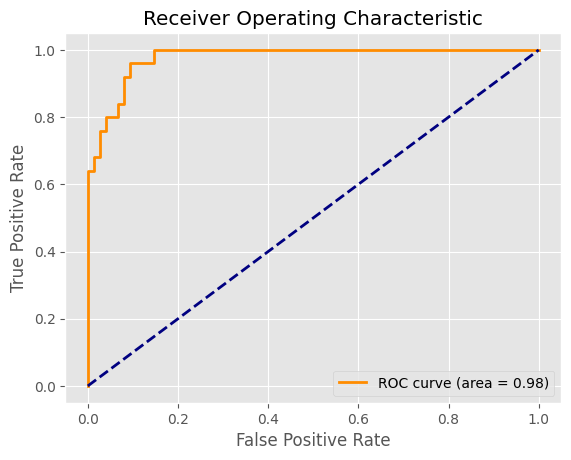

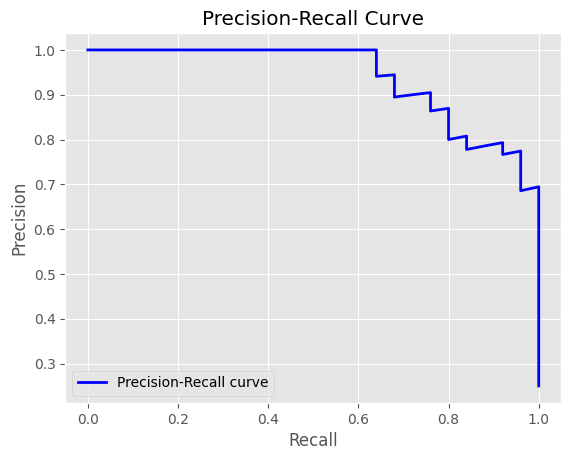

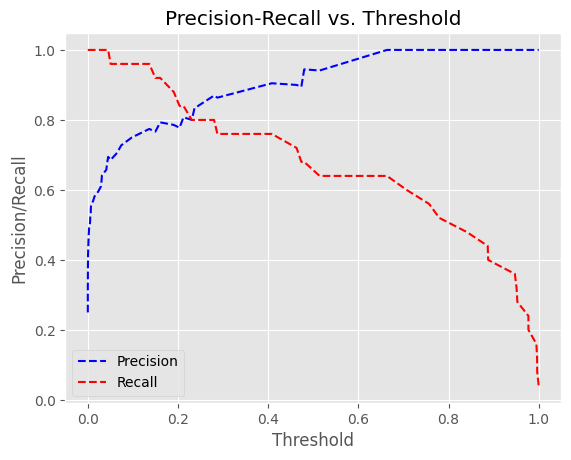

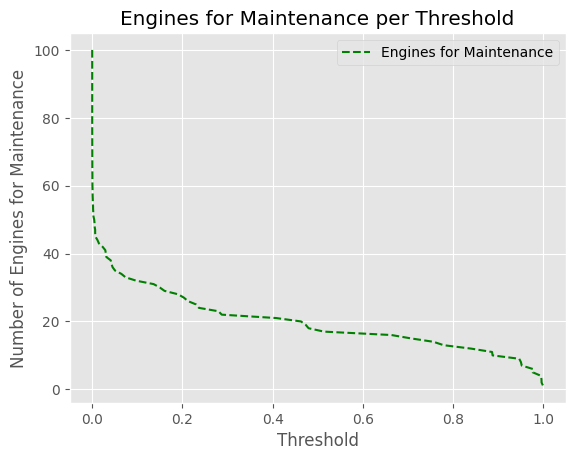

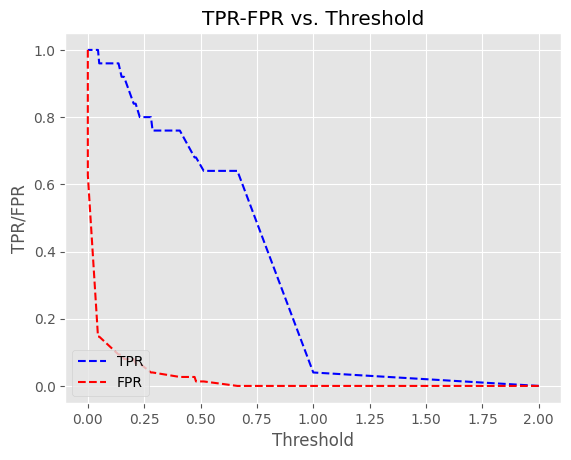

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Calculate probabilities for the positive class
y_scores = Bestparam_rf.predict_proba(d_test[features])[:, 1]

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Precision-Recall vs. Threshold
plt.figure()
plt.plot(thresholds_pr, precision[:-1], "b--", label="Precision")
plt.plot(thresholds_pr, recall[:-1], "r--", label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall vs. Threshold')
plt.legend(loc="lower left")
plt.show()

# Number of engines predicted for maintenance per period
maintenance_count = [sum(y_scores >= t) for t in thresholds_pr]

plt.figure()
plt.plot(thresholds_pr, maintenance_count, "g--", label="Engines for Maintenance")
plt.xlabel('Threshold')
plt.ylabel('Number of Engines for Maintenance')
plt.title('Engines for Maintenance per Threshold')
plt.legend(loc="upper right")
plt.show()

# TPR-FPR vs. Threshold
plt.figure()
plt.plot(thresholds_roc, tpr, "b--", label="TPR")
plt.plot(thresholds_roc, fpr, "r--", label="FPR")
plt.xlabel('Threshold')
plt.ylabel('TPR/FPR')
plt.title('TPR-FPR vs. Threshold')
plt.legend(loc="lower left")
plt.show()


##**A.4 SVC**##

Just as the Logistic regression, we're gonna tune and then evaluate.

If the hyperplane classifies the dataset linearly then the algorithm we call it as SVC and the algorithm that separates the dataset by non-linear approach then we call it as SVM.

In [16]:
model = 'SVC'
clf_svc = SVC(kernel='rbf', random_state=123)
gs_params = {'C': [1.0], 'cache_size':[200],  'coef0':[0.0],
  'degree':[3], 'gamma':['auto'], 'kernel':['rbf'],
   'tol':[0.001],'probability':[True]}
gs_score = 'roc_auc'

# Perform grid search
Bestparam_svc, pred_svc = tuning(model, clf_svc, params=gs_params, score=gs_score, features=features, y_train=y_train)
print('\nBest Parameters for Decision Tree:\n', Bestparam_svc)



Best Parameters for Decision Tree:
 SVC(gamma='auto', probability=True, random_state=123)


In [41]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score, f1_score

y_pred = Bestparam_svc.predict(d_test[features])

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

roc_auc_svc = roc_auc_score(y_test, Bestparam_svc.predict_proba(d_test[features])[:, 1])
recall_svc = recall_score(y_test, y_pred)
accuracy_svc = accuracy_score(y_test, y_pred)
precision_svc = precision_score(y_test, y_pred)
f1_svc = f1_score(y_test, y_pred)

print("\nMetrics:")
print("ROC AUC:", roc_auc_svc)
print("Recall:", recall_svc)
print("Accuracy:", accuracy_svc)
print("Precision:", precision_svc)
print("F1 Score:", f1_svc)


Confusion Matrix:
 [[74  1]
 [ 8 17]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94        75
           1       0.94      0.68      0.79        25

    accuracy                           0.91       100
   macro avg       0.92      0.83      0.87       100
weighted avg       0.91      0.91      0.90       100


Metrics:
ROC AUC: 0.9034666666666666
Recall: 0.68
Accuracy: 0.91
Precision: 0.9444444444444444
F1 Score: 0.7906976744186047


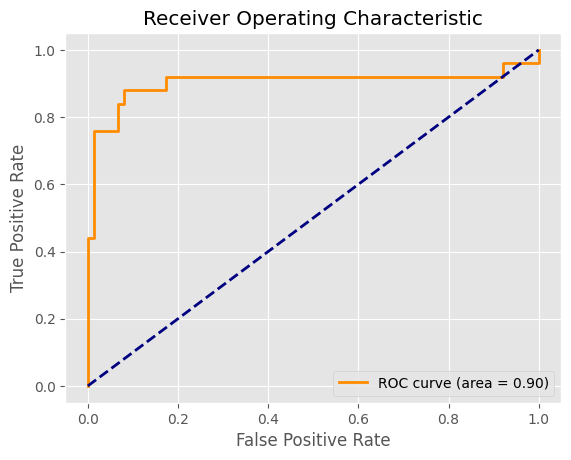

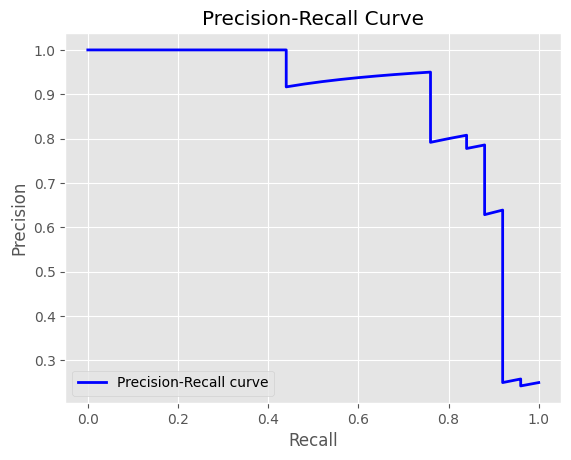

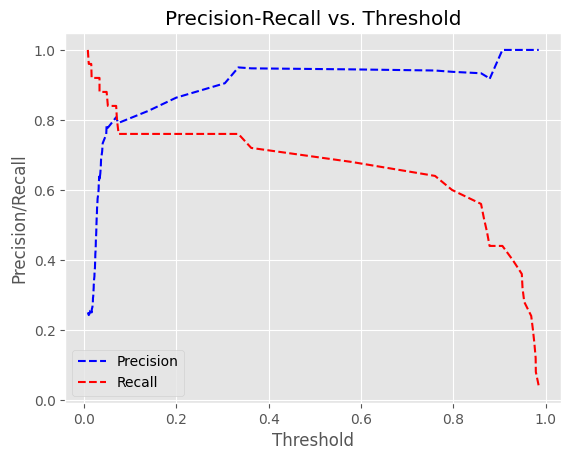

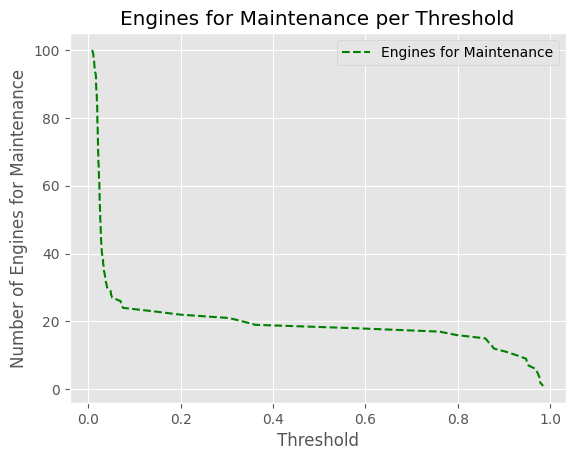

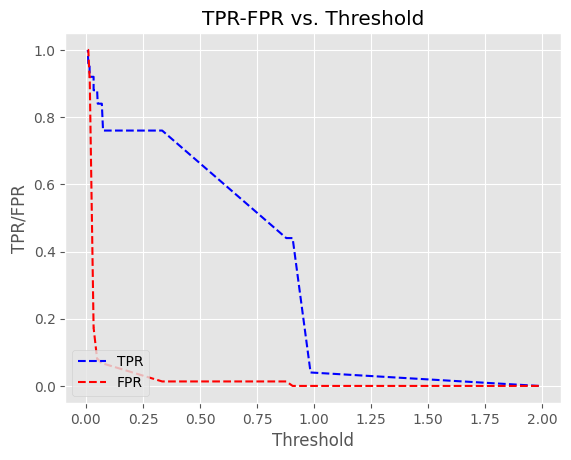

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Calculate probabilities for the positive class
y_scores = Bestparam_svc.predict_proba(d_test[features])[:, 1]

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Precision-Recall vs. Threshold
plt.figure()
plt.plot(thresholds_pr, precision[:-1], "b--", label="Precision")
plt.plot(thresholds_pr, recall[:-1], "r--", label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall vs. Threshold')
plt.legend(loc="lower left")
plt.show()

# Number of engines predicted for maintenance per period
maintenance_count = [sum(y_scores >= t) for t in thresholds_pr]

plt.figure()
plt.plot(thresholds_pr, maintenance_count, "g--", label="Engines for Maintenance")
plt.xlabel('Threshold')
plt.ylabel('Number of Engines for Maintenance')
plt.title('Engines for Maintenance per Threshold')
plt.legend(loc="upper right")
plt.show()

# TPR-FPR vs. Threshold
plt.figure()
plt.plot(thresholds_roc, tpr, "b--", label="TPR")
plt.plot(thresholds_roc, fpr, "r--", label="FPR")
plt.xlabel('Threshold')
plt.ylabel('TPR/FPR')
plt.title('TPR-FPR vs. Threshold')
plt.legend(loc="lower left")
plt.show()


##**A.5 KNN**##

Just as the Logistic regression, we're gonna tune and then evaluate.

In [26]:
model = 'KNN'
clf_knn = KNeighborsClassifier(n_jobs=-1 , algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, p=2,
           weights='uniform')
gs_params = {'n_neighbors': [9, 10, 11, 12, 13]}


gs_score = 'roc_auc'

# Perform grid search
Bestparam_knn, pred_knn = tuning(model, clf_knn, params=gs_params, score=gs_score, features=features, y_train=y_train)
print('\nBest Parameters for KNN:\n', Bestparam_knn)



Best Parameters for KNN:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=13)


In [42]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score, f1_score

y_pred = Bestparam_knn.predict(d_test[features])

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

roc_auc_knn = roc_auc_score(y_test, Bestparam_knn.predict_proba(d_test[features])[:, 1])
recall_knn = recall_score(y_test, y_pred)
accuracy_knn = accuracy_score(y_test, y_pred)
precision_knn = precision_score(y_test, y_pred)
f1_knn = f1_score(y_test, y_pred)

print("\nMetrics:")
print("ROC AUC:", roc_auc_knn)
print("Recall:", recall_knn)
print("Accuracy:", accuracy_knn)
print("Precision:", precision_knn)
print("F1 Score:", f1_knn)


Confusion Matrix:
 [[74  1]
 [ 8 17]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94        75
           1       0.94      0.68      0.79        25

    accuracy                           0.91       100
   macro avg       0.92      0.83      0.87       100
weighted avg       0.91      0.91      0.90       100


Metrics:
ROC AUC: 0.9352
Recall: 0.68
Accuracy: 0.91
Precision: 0.9444444444444444
F1 Score: 0.7906976744186047


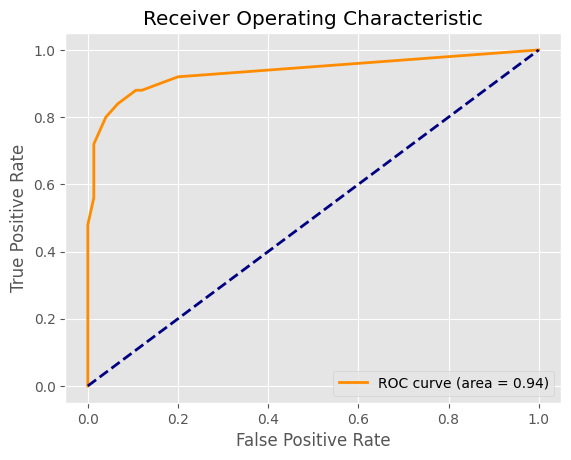

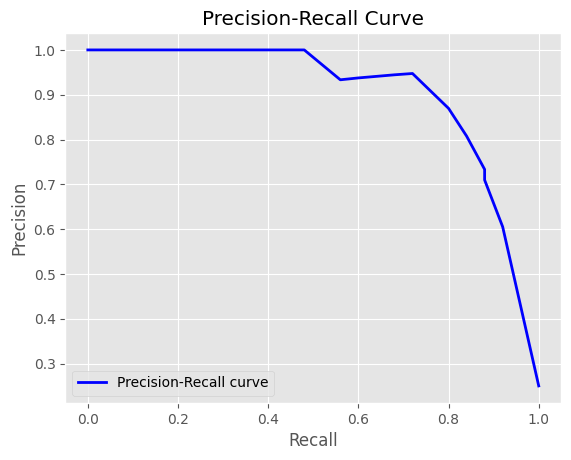

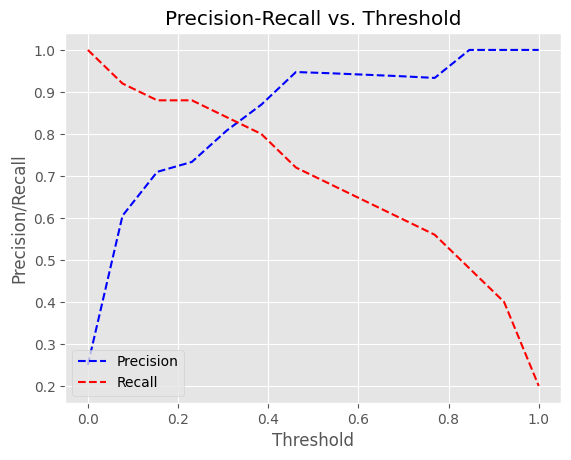

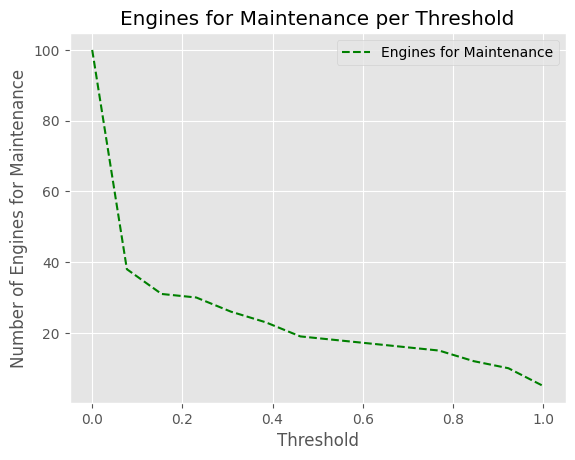

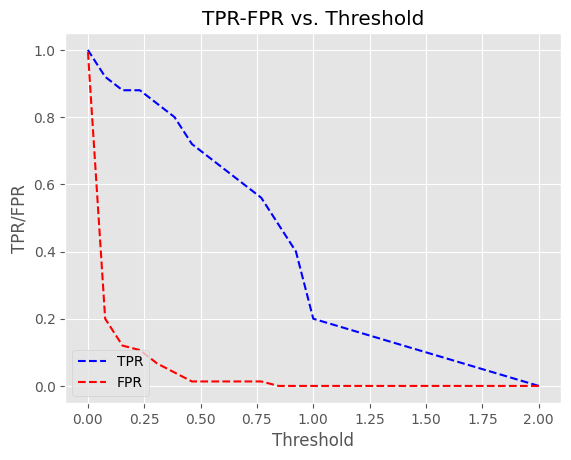

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Calculate probabilities for the positive class
y_scores = Bestparam_knn.predict_proba(d_test[features])[:, 1]

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Precision-Recall vs. Threshold
plt.figure()
plt.plot(thresholds_pr, precision[:-1], "b--", label="Precision")
plt.plot(thresholds_pr, recall[:-1], "r--", label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall vs. Threshold')
plt.legend(loc="lower left")
plt.show()

# Number of engines predicted for maintenance per period
maintenance_count = [sum(y_scores >= t) for t in thresholds_pr]

plt.figure()
plt.plot(thresholds_pr, maintenance_count, "g--", label="Engines for Maintenance")
plt.xlabel('Threshold')
plt.ylabel('Number of Engines for Maintenance')
plt.title('Engines for Maintenance per Threshold')
plt.legend(loc="upper right")
plt.show()

# TPR-FPR vs. Threshold
plt.figure()
plt.plot(thresholds_roc, tpr, "b--", label="TPR")
plt.plot(thresholds_roc, fpr, "r--", label="FPR")
plt.xlabel('Threshold')
plt.ylabel('TPR/FPR')
plt.title('TPR-FPR vs. Threshold')
plt.legend(loc="lower left")
plt.show()


##**A.6 Gaussian Naive Bayes**##

Just as the Logistic regression, we're gonna tune and then evaluate.

In [27]:
model = 'GNB'
clf_gnb = GaussianNB()
gs_params = {}

gs_score = 'roc_auc'

# Perform grid search
Bestparam_gnb, pred_gnb = tuning(model, clf_gnb, params=gs_params, score=gs_score, features=features, y_train=y_train)
print('\nBest Parameters for GNB:\n', Bestparam_gnb)



Best Parameters for GNB:
 GaussianNB()


In [43]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score, f1_score

y_pred = Bestparam_gnb.predict(d_test[features])

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

roc_auc_gnb = roc_auc_score(y_test, Bestparam_gnb.predict_proba(d_test[features])[:, 1])
recall_gnb = recall_score(y_test, y_pred)
accuracy_gnb = accuracy_score(y_test, y_pred)
precision_gnb = precision_score(y_test, y_pred)
f1_gnb = f1_score(y_test, y_pred)

print("\nMetrics:")
print("ROC AUC:", roc_auc_gnb)
print("Recall:", recall_gnb)
print("Accuracy:", accuracy_gnb)
print("Precision:", precision_gnb)
print("F1 Score:", f1_gnb)


Confusion Matrix:
 [[70  5]
 [ 1 24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96        75
           1       0.83      0.96      0.89        25

    accuracy                           0.94       100
   macro avg       0.91      0.95      0.92       100
weighted avg       0.95      0.94      0.94       100


Metrics:
ROC AUC: 0.9877333333333334
Recall: 0.96
Accuracy: 0.94
Precision: 0.8275862068965517
F1 Score: 0.888888888888889


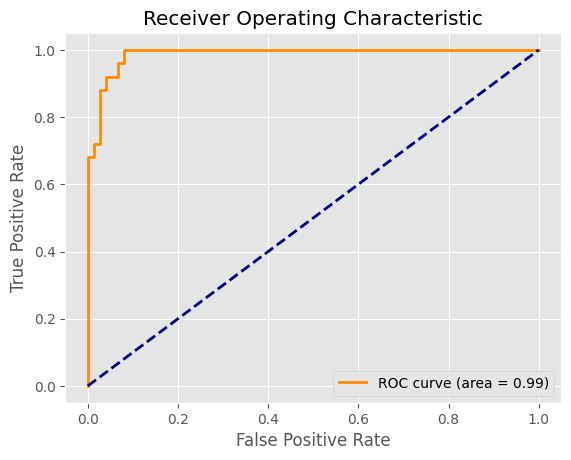

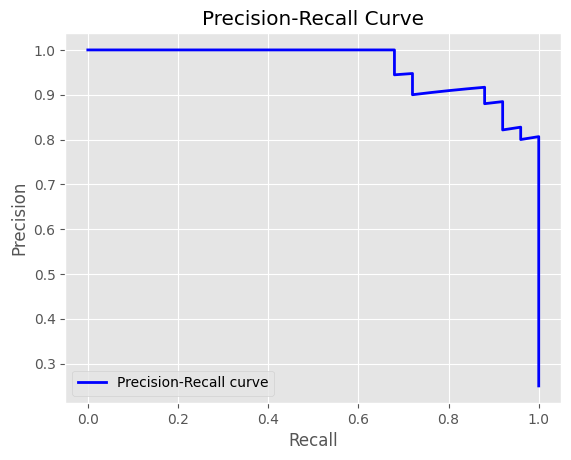

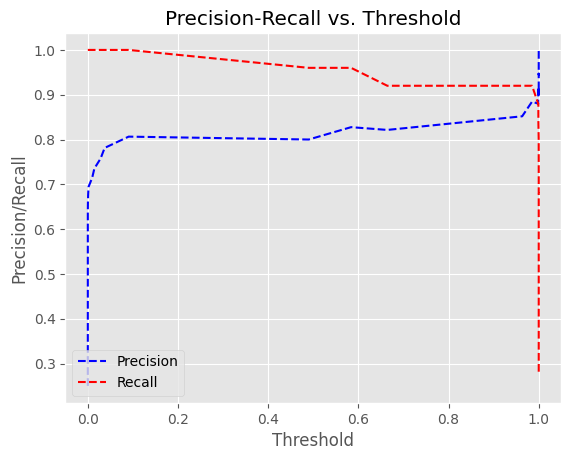

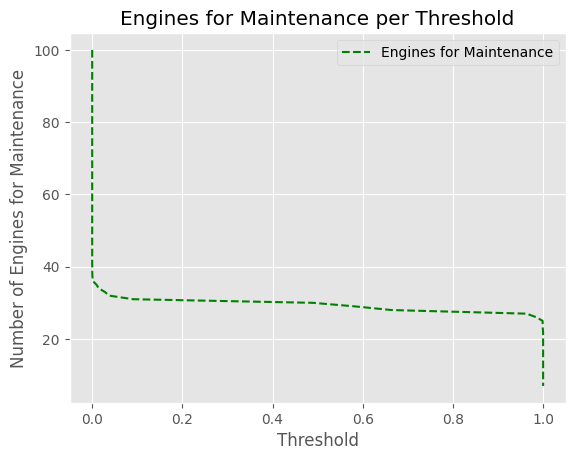

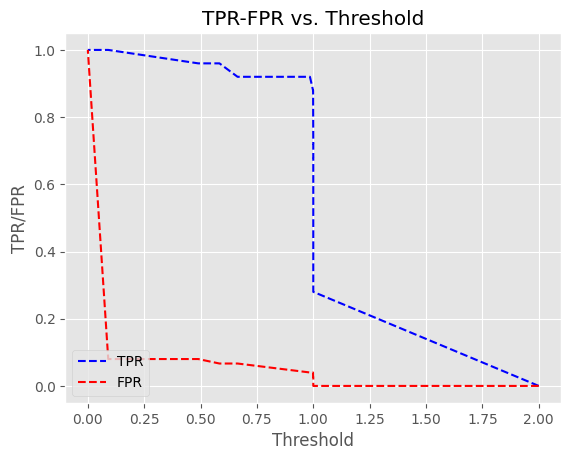

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Calculate probabilities for the positive class
y_scores = Bestparam_gnb.predict_proba(d_test[features])[:, 1]

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Precision-Recall vs. Threshold
plt.figure()
plt.plot(thresholds_pr, precision[:-1], "b--", label="Precision")
plt.plot(thresholds_pr, recall[:-1], "r--", label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall vs. Threshold')
plt.legend(loc="lower left")
plt.show()

# Number of engines predicted for maintenance per period
maintenance_count = [sum(y_scores >= t) for t in thresholds_pr]

plt.figure()
plt.plot(thresholds_pr, maintenance_count, "g--", label="Engines for Maintenance")
plt.xlabel('Threshold')
plt.ylabel('Number of Engines for Maintenance')
plt.title('Engines for Maintenance per Threshold')
plt.legend(loc="upper right")
plt.show()

# TPR-FPR vs. Threshold
plt.figure()
plt.plot(thresholds_roc, tpr, "b--", label="TPR")
plt.plot(thresholds_roc, fpr, "r--", label="FPR")
plt.xlabel('Threshold')
plt.ylabel('TPR/FPR')
plt.title('TPR-FPR vs. Threshold')
plt.legend(loc="lower left")
plt.show()


##**Summary**##

Let's Compare all binary classification algorithms tested based on the metrics.

In [44]:
metrics_lr = {'ROC AUC': roc_auc_lr, 'Recall': recall_lr, 'Accuracy': accuracy_lr, 'Precision': precision_lr, 'F1 Score': f1_lr}
metrics_dt = {'ROC AUC': roc_auc_dt, 'Recall': recall_dt, 'Accuracy': accuracy_dt, 'Precision': precision_dt, 'F1 Score': f1_dt}
metrics_rf = {'ROC AUC': roc_auc_rf, 'Recall': recall_rf, 'Accuracy': accuracy_rf, 'Precision': precision_rf, 'F1 Score': f1_rf}
metrics_svc = {'ROC AUC': roc_auc_svc, 'Recall': recall_svc, 'Accuracy': accuracy_svc, 'Precision': precision_svc, 'F1 Score': f1_svc}
metrics_knn = {'ROC AUC': roc_auc_knn, 'Recall': recall_knn, 'Accuracy': accuracy_knn, 'Precision': precision_knn, 'F1 Score': f1_knn}
metrics_gnb = {'ROC AUC': roc_auc_gnb, 'Recall': recall_gnb, 'Accuracy': accuracy_gnb, 'Precision': precision_gnb, 'F1 Score': f1_gnb}

models_comparison = pd.DataFrame({
    'Logistic Regression': metrics_lr,
    'Decision Tree': metrics_dt,
    'Random Forest': metrics_rf,
    'SVC': metrics_svc,
    'KNN': metrics_knn,
    'Gaussian Naive Bayes': metrics_gnb
})


models_comparison = models_comparison.T

print(models_comparison)

                       ROC AUC  Recall  Accuracy  Precision  F1 Score
Logistic Regression   0.979200    0.68      0.91   0.944444  0.790698
Decision Tree         0.944533    0.56      0.88   0.933333  0.700000
Random Forest         0.977067    0.64      0.90   0.941176  0.761905
SVC                   0.903467    0.68      0.91   0.944444  0.790698
KNN                   0.935200    0.68      0.91   0.944444  0.790698
Gaussian Naive Bayes  0.987733    0.96      0.94   0.827586  0.888889


- G Naïve Bayes Random Forests and Logistic Regresion scored best AUC ROC.

- Although SVC has the lowest AUC-ROC, it has the best precision-recall alongside with Logistic Regression.

- Logistic Regression seems like a powerful model in this case.

#**B.Training on original features+ features added**#

This time, we're using the added features. To do it, we should change the variable features.

In [45]:
features=features_added

##**B.1. Logistic Regression**##

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
model = 'Logistic Regression B'
clf_lgr = LogisticRegression(random_state=123)
gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'
clf_lgr = make_pipeline(StandardScaler(), LogisticRegression(random_state=123, max_iter=1000))
clf_lgr = make_pipeline(StandardScaler(), LogisticRegression(random_state=123, max_iter=1000))
gs_params = {'logisticregression__C': [.01, 0.1, 1.0, 10], 'logisticregression__solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'

Bestparam, pred_lgr = tuning(model, clf_lgr, params=gs_params, score=gs_score,features=features, y_train=y_train)
print('\nBest Parameters:\n', Bestparam)


Best Parameters:
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=123))])


Now as we found the best parameters, let's evaluate.

In [47]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score, f1_score


y_pred = Bestparam.predict(d_test[features])

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Calculating Metrics
roc_auc_lr = roc_auc_score(y_test, Bestparam.predict_proba(d_test[features])[:, 1])
recall_lr= recall_score(y_test, y_pred)
accuracy_lr = accuracy_score(y_test, y_pred)
precision_lr= precision_score(y_test, y_pred)
f1_lr= f1_score(y_test, y_pred)

# Print the metrics
print("\nMetrics:")
print("ROC AUC:", roc_auc_lr)
print("Recall:", recall_lr)
print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("F1 Score:", f1_lr)


Confusion Matrix:
 [[74  1]
 [ 7 18]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95        75
           1       0.95      0.72      0.82        25

    accuracy                           0.92       100
   macro avg       0.93      0.85      0.88       100
weighted avg       0.92      0.92      0.92       100


Metrics:
ROC AUC: 0.9813333333333333
Recall: 0.72
Accuracy: 0.92
Precision: 0.9473684210526315
F1 Score: 0.8181818181818181


Now let's plot:
- Plot: AUC ROC
- Plot: Precision-Recall curve
- Plot: Precision-Recall threshold, also show the number of engines predicted for maintenace per period
- Plot: TPR-FPR threshold ( True Positive rate vs False Positive rate)
        

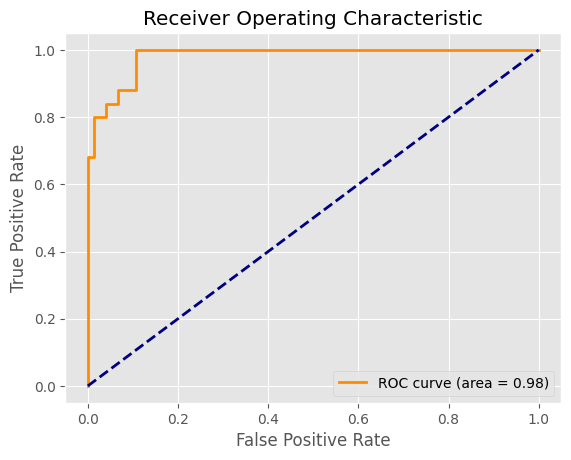

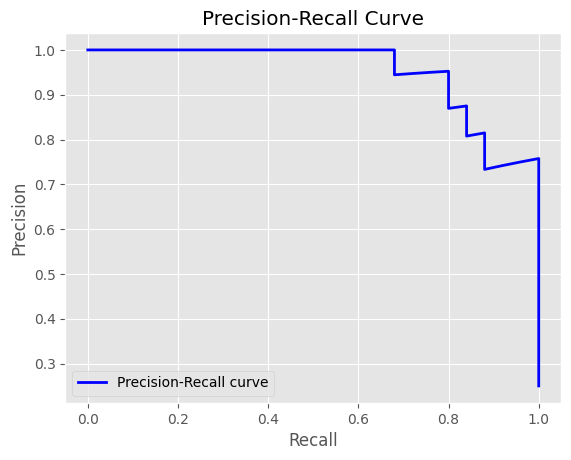

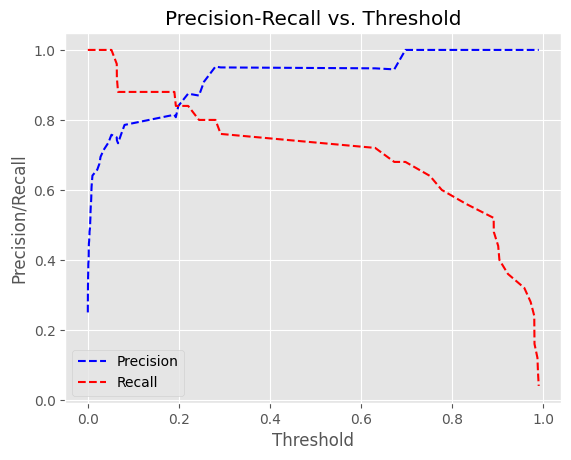

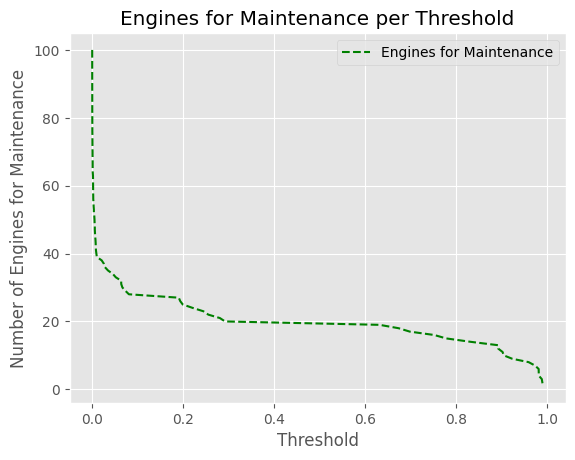

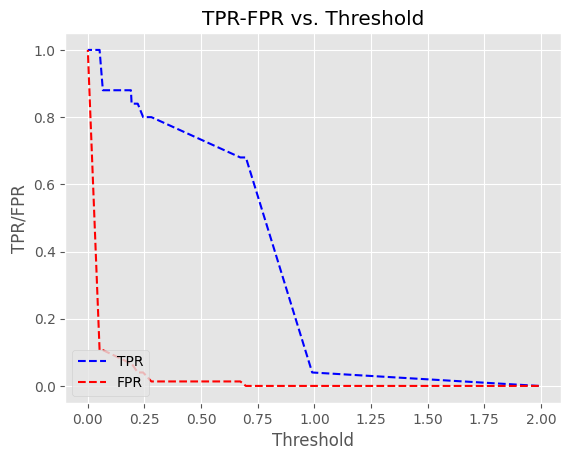

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score

X_test=d_test[features]
# Calculate probabilities
y_scores = Bestparam.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Precision-Recall vs. Threshold
plt.figure()
plt.plot(thresholds_pr, precision[:-1], "b--", label="Precision")
plt.plot(thresholds_pr, recall[:-1], "r--", label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall vs. Threshold')
plt.legend(loc="lower left")
plt.show()

# Number of engines predicted for maintenance per period
maintenance_count = [sum(y_scores >= t) for t in thresholds_pr]

plt.figure()
plt.plot(thresholds_pr, maintenance_count, "g--", label="Engines for Maintenance")
plt.xlabel('Threshold')
plt.ylabel('Number of Engines for Maintenance')
plt.title('Engines for Maintenance per Threshold')
plt.legend(loc="upper right")
plt.show()

# TPR-FPR vs. Threshold
plt.figure()
plt.plot(thresholds_roc, tpr, "b--", label="TPR")
plt.plot(thresholds_roc, fpr, "r--", label="FPR")
plt.xlabel('Threshold')
plt.ylabel('TPR/FPR')
plt.title('TPR-FPR vs. Threshold')
plt.legend(loc="lower left")
plt.show()


Engines in the above charts represent the number of engines to be maintain per period, the maintenance capacity.

##**B.2 Decision Tree**##

Just as the Logistic regression, we're gonna tune and then evaluate.

In [49]:
model = 'Decision Tree'
clf_dt = DecisionTreeClassifier(random_state=123)

dt_params = {
    'max_depth': [2, 3, 4, 5, 6], 'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gs_score = 'roc_auc'

# Perform grid search
Bestparam_dt, pred_dt = tuning(model, clf_dt, params=dt_params, score=gs_score, features=features, y_train=y_train)
print('\nBest Parameters for Decision Tree:\n', Bestparam_dt)



Best Parameters for Decision Tree:
 DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)


In [50]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score, f1_score

y_pred = Bestparam_dt.predict(d_test[features])

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

roc_auc_dt = roc_auc_score(y_test, Bestparam_dt.predict_proba(d_test[features])[:, 1])
recall_dt= recall_score(y_test, y_pred)
accuracy_dt = accuracy_score(y_test, y_pred)
precision_dt = precision_score(y_test, y_pred)
f1_dt= f1_score(y_test, y_pred)

print("\nMetrics:")
print("ROC AUC:", roc_auc_dt)
print("Recall:", recall_dt)
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("F1 Score:", f1_dt)


Confusion Matrix:
 [[74  1]
 [ 7 18]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95        75
           1       0.95      0.72      0.82        25

    accuracy                           0.92       100
   macro avg       0.93      0.85      0.88       100
weighted avg       0.92      0.92      0.92       100


Metrics:
ROC AUC: 0.9629333333333333
Recall: 0.72
Accuracy: 0.92
Precision: 0.9473684210526315
F1 Score: 0.8181818181818181


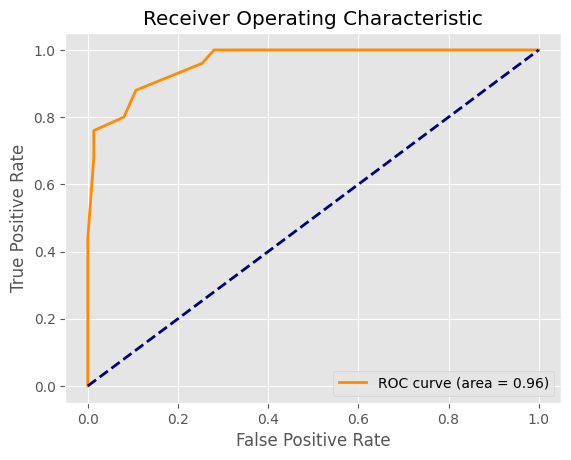

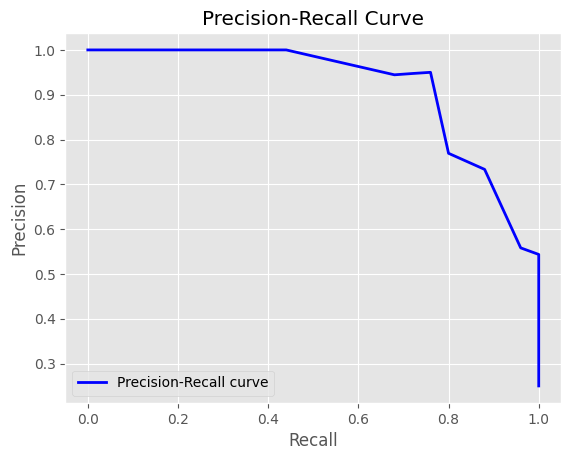

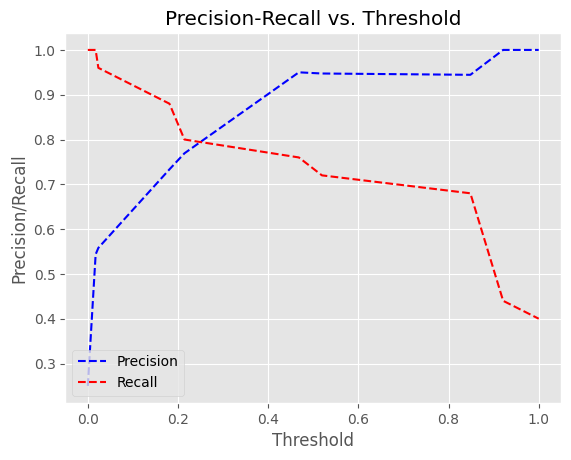

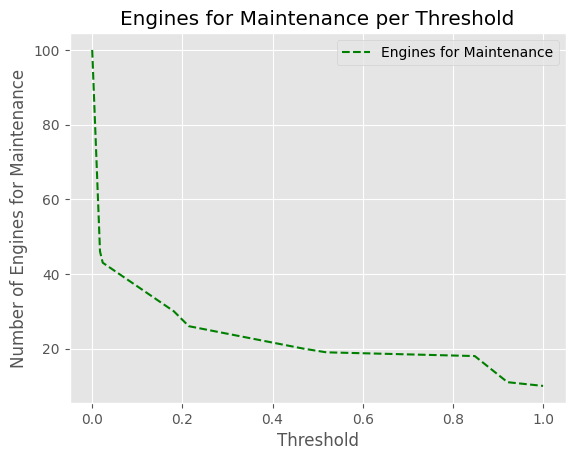

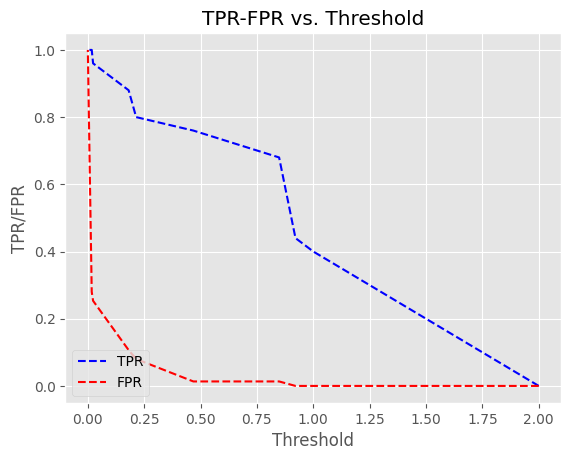

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Calculate probabilities for the positive class
y_scores = Bestparam_dt.predict_proba(d_test[features])[:, 1]

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Precision-Recall vs. Threshold
plt.figure()
plt.plot(thresholds_pr, precision[:-1], "b--", label="Precision")
plt.plot(thresholds_pr, recall[:-1], "r--", label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall vs. Threshold')
plt.legend(loc="lower left")
plt.show()

# Number of engines predicted for maintenance per period
maintenance_count = [sum(y_scores >= t) for t in thresholds_pr]

plt.figure()
plt.plot(thresholds_pr, maintenance_count, "g--", label="Engines for Maintenance")
plt.xlabel('Threshold')
plt.ylabel('Number of Engines for Maintenance')
plt.title('Engines for Maintenance per Threshold')
plt.legend(loc="upper right")
plt.show()

# TPR-FPR vs. Threshold
plt.figure()
plt.plot(thresholds_roc, tpr, "b--", label="TPR")
plt.plot(thresholds_roc, fpr, "r--", label="FPR")
plt.xlabel('Threshold')
plt.ylabel('TPR/FPR')
plt.title('TPR-FPR vs. Threshold')
plt.legend(loc="lower left")
plt.show()


##**B.3 Random Forest**##

Just as the Logistic regression, we're gonna tune and then evaluate.

In [52]:
model = 'Random Forest'
clf_rf = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}


gs_score = 'roc_auc'

# Perform grid search
Bestparam_rf, pred_rf = tuning(model, clf_rf, params=gs_params, score=gs_score, features=features, y_train=y_train)
print('\nBest Parameters for Decision Tree:\n', Bestparam_rf)



Best Parameters for Decision Tree:
 RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=50,
                       random_state=123)


In [53]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score, f1_score

y_pred = Bestparam_rf.predict(d_test[features])

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

roc_auc_rf = roc_auc_score(y_test, Bestparam_rf.predict_proba(d_test[features])[:, 1])
recall_rf= recall_score(y_test, y_pred)
accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred)
f1_rf= f1_score(y_test, y_pred)

print("\nMetrics:")
print("ROC AUC:", roc_auc_rf)
print("Recall:", recall_rf)
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("F1 Score:", f1_rf)


Confusion Matrix:
 [[74  1]
 [ 9 16]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94        75
           1       0.94      0.64      0.76        25

    accuracy                           0.90       100
   macro avg       0.92      0.81      0.85       100
weighted avg       0.90      0.90      0.89       100


Metrics:
ROC AUC: 0.9834666666666667
Recall: 0.64
Accuracy: 0.9
Precision: 0.9411764705882353
F1 Score: 0.7619047619047621


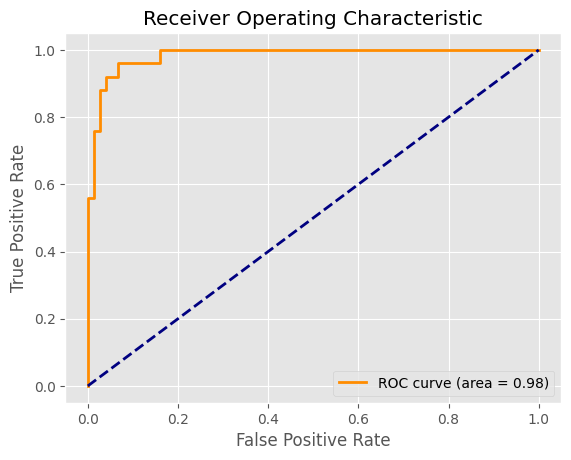

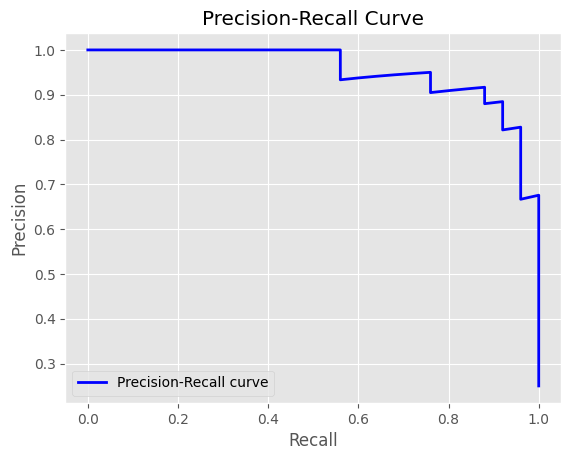

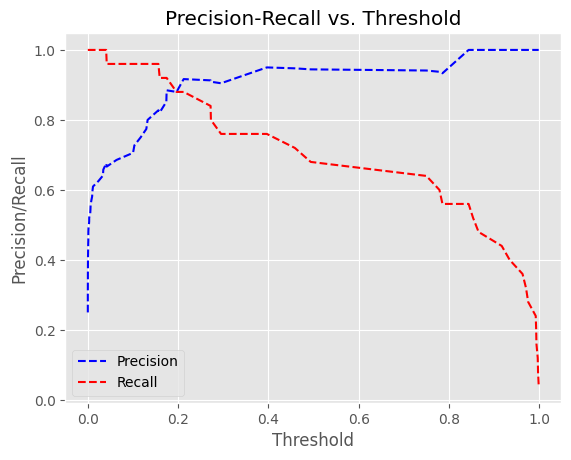

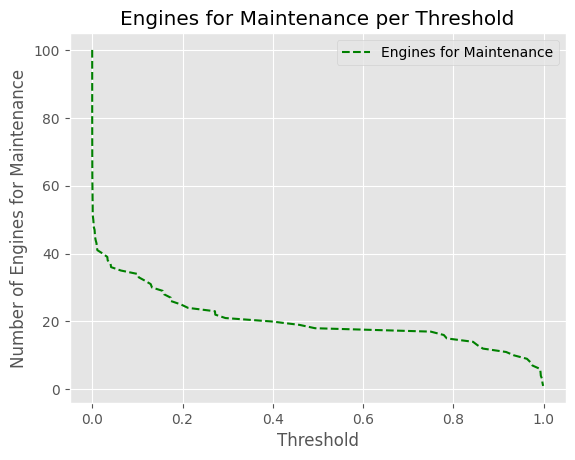

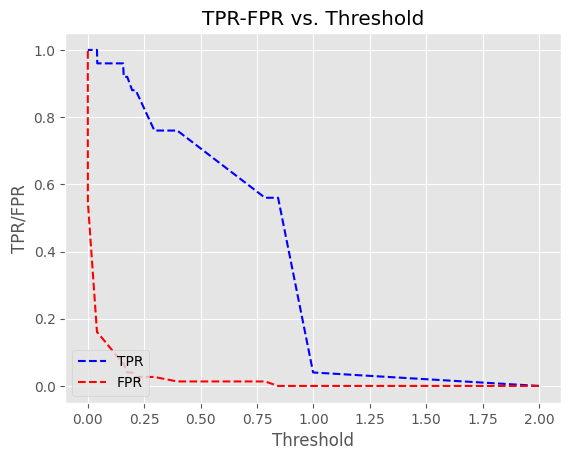

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Calculate probabilities for the positive class
y_scores = Bestparam_rf.predict_proba(d_test[features])[:, 1]

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Precision-Recall vs. Threshold
plt.figure()
plt.plot(thresholds_pr, precision[:-1], "b--", label="Precision")
plt.plot(thresholds_pr, recall[:-1], "r--", label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall vs. Threshold')
plt.legend(loc="lower left")
plt.show()

# Number of engines predicted for maintenance per period
maintenance_count = [sum(y_scores >= t) for t in thresholds_pr]

plt.figure()
plt.plot(thresholds_pr, maintenance_count, "g--", label="Engines for Maintenance")
plt.xlabel('Threshold')
plt.ylabel('Number of Engines for Maintenance')
plt.title('Engines for Maintenance per Threshold')
plt.legend(loc="upper right")
plt.show()

# TPR-FPR vs. Threshold
plt.figure()
plt.plot(thresholds_roc, tpr, "b--", label="TPR")
plt.plot(thresholds_roc, fpr, "r--", label="FPR")
plt.xlabel('Threshold')
plt.ylabel('TPR/FPR')
plt.title('TPR-FPR vs. Threshold')
plt.legend(loc="lower left")
plt.show()


##**B.4 SVC**##

Just as the Logistic regression, we're gonna tune and then evaluate.

If the hyperplane classifies the dataset linearly then the algorithm we call it as SVC and the algorithm that separates the dataset by non-linear approach then we call it as SVM.

In [55]:
model = 'SVC'
clf_svc = SVC(kernel='rbf', random_state=123)
gs_params = {'C': [1.0], 'cache_size':[200],  'coef0':[0.0],
  'degree':[3], 'gamma':['auto'], 'kernel':['rbf'],
   'tol':[0.001],'probability':[True]}
gs_score = 'roc_auc'

# Perform grid search
Bestparam_svc, pred_svc = tuning(model, clf_svc, params=gs_params, score=gs_score, features=features, y_train=y_train)
print('\nBest Parameters for Decision Tree:\n', Bestparam_svc)



Best Parameters for Decision Tree:
 SVC(gamma='auto', probability=True, random_state=123)


In [56]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score, f1_score

y_pred = Bestparam_svc.predict(d_test[features])

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

roc_auc_svc = roc_auc_score(y_test, Bestparam_svc.predict_proba(d_test[features])[:, 1])
recall_svc = recall_score(y_test, y_pred)
accuracy_svc = accuracy_score(y_test, y_pred)
precision_svc = precision_score(y_test, y_pred)
f1_svc = f1_score(y_test, y_pred)

print("\nMetrics:")
print("ROC AUC:", roc_auc_svc)
print("Recall:", recall_svc)
print("Accuracy:", accuracy_svc)
print("Precision:", precision_svc)
print("F1 Score:", f1_svc)


Confusion Matrix:
 [[74  1]
 [ 7 18]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95        75
           1       0.95      0.72      0.82        25

    accuracy                           0.92       100
   macro avg       0.93      0.85      0.88       100
weighted avg       0.92      0.92      0.92       100


Metrics:
ROC AUC: 0.9264
Recall: 0.72
Accuracy: 0.92
Precision: 0.9473684210526315
F1 Score: 0.8181818181818181


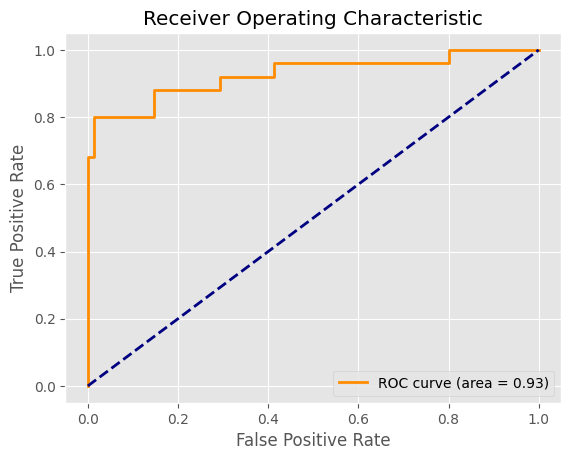

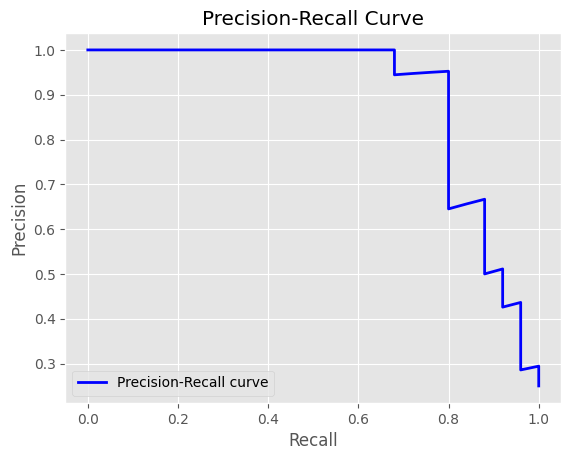

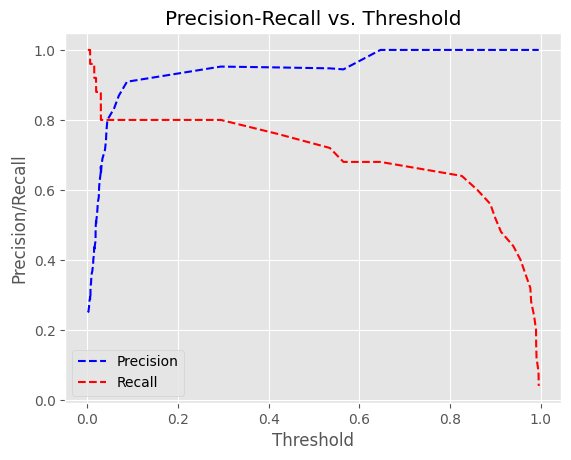

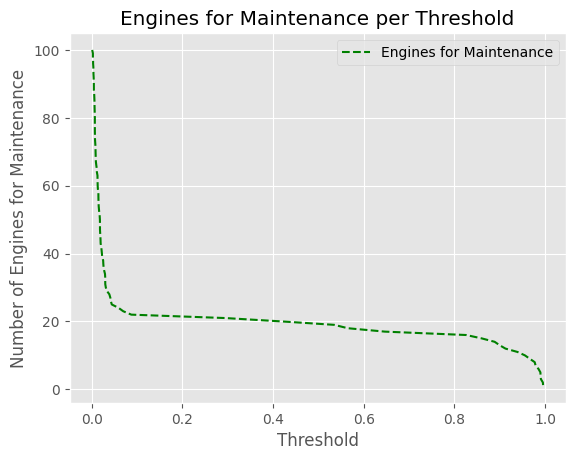

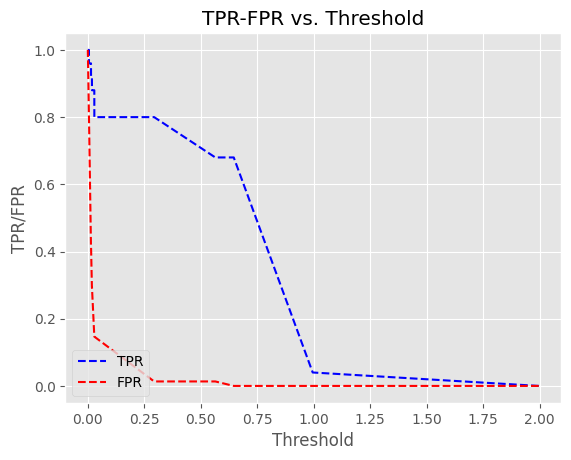

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Calculate probabilities for the positive class
y_scores = Bestparam_svc.predict_proba(d_test[features])[:, 1]

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Precision-Recall vs. Threshold
plt.figure()
plt.plot(thresholds_pr, precision[:-1], "b--", label="Precision")
plt.plot(thresholds_pr, recall[:-1], "r--", label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall vs. Threshold')
plt.legend(loc="lower left")
plt.show()

# Number of engines predicted for maintenance per period
maintenance_count = [sum(y_scores >= t) for t in thresholds_pr]

plt.figure()
plt.plot(thresholds_pr, maintenance_count, "g--", label="Engines for Maintenance")
plt.xlabel('Threshold')
plt.ylabel('Number of Engines for Maintenance')
plt.title('Engines for Maintenance per Threshold')
plt.legend(loc="upper right")
plt.show()

# TPR-FPR vs. Threshold
plt.figure()
plt.plot(thresholds_roc, tpr, "b--", label="TPR")
plt.plot(thresholds_roc, fpr, "r--", label="FPR")
plt.xlabel('Threshold')
plt.ylabel('TPR/FPR')
plt.title('TPR-FPR vs. Threshold')
plt.legend(loc="lower left")
plt.show()


##**B.5 KNN**##

Just as the Logistic regression, we're gonna tune and then evaluate.

In [58]:
model = 'KNN'
clf_knn = KNeighborsClassifier(n_jobs=-1 , algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, p=2,
           weights='uniform')
gs_params = {'n_neighbors': [9, 10, 11, 12, 13]}


gs_score = 'roc_auc'

# Perform grid search
Bestparam_knn, pred_knn = tuning(model, clf_knn, params=gs_params, score=gs_score, features=features, y_train=y_train)
print('\nBest Parameters for KNN:\n', Bestparam_knn)



Best Parameters for KNN:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=13)


In [59]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score, f1_score

y_pred = Bestparam_knn.predict(d_test[features])

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

roc_auc_knn = roc_auc_score(y_test, Bestparam_knn.predict_proba(d_test[features])[:, 1])
recall_knn = recall_score(y_test, y_pred)
accuracy_knn = accuracy_score(y_test, y_pred)
precision_knn = precision_score(y_test, y_pred)
f1_knn = f1_score(y_test, y_pred)

print("\nMetrics:")
print("ROC AUC:", roc_auc_knn)
print("Recall:", recall_knn)
print("Accuracy:", accuracy_knn)
print("Precision:", precision_knn)
print("F1 Score:", f1_knn)


Confusion Matrix:
 [[74  1]
 [ 7 18]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95        75
           1       0.95      0.72      0.82        25

    accuracy                           0.92       100
   macro avg       0.93      0.85      0.88       100
weighted avg       0.92      0.92      0.92       100


Metrics:
ROC AUC: 0.9634666666666666
Recall: 0.72
Accuracy: 0.92
Precision: 0.9473684210526315
F1 Score: 0.8181818181818181


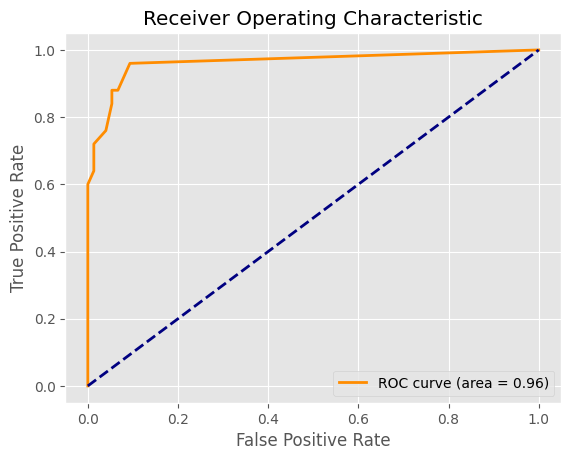

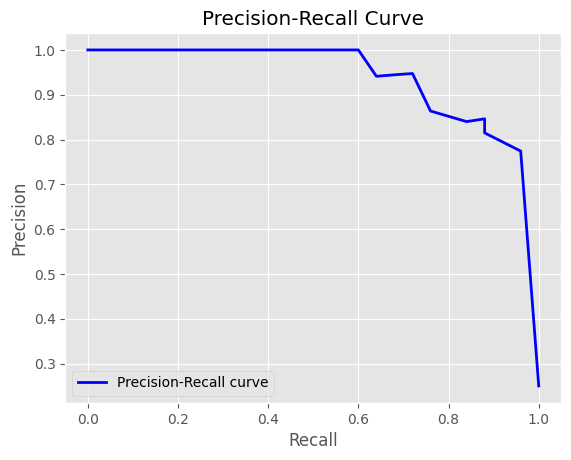

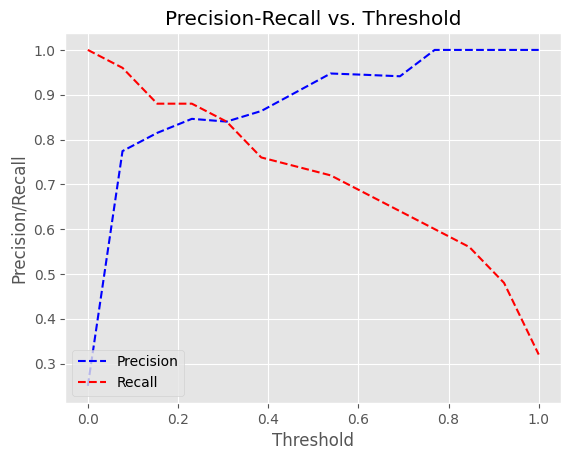

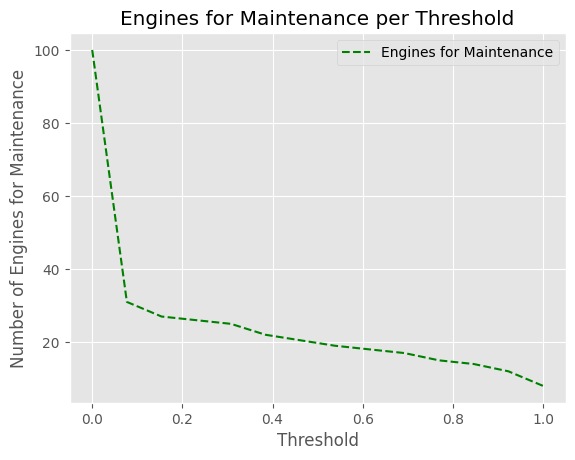

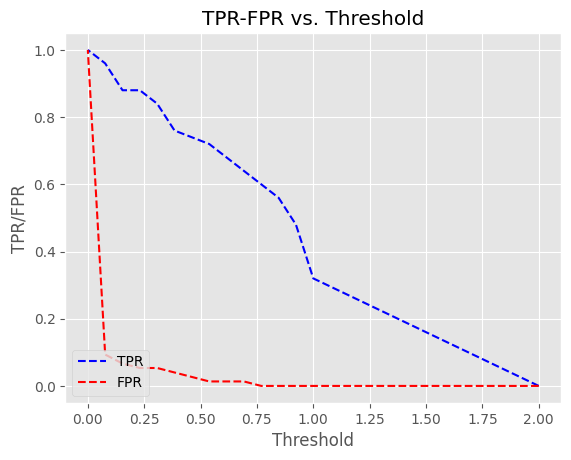

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Calculate probabilities for the positive class
y_scores = Bestparam_knn.predict_proba(d_test[features])[:, 1]

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Precision-Recall vs. Threshold
plt.figure()
plt.plot(thresholds_pr, precision[:-1], "b--", label="Precision")
plt.plot(thresholds_pr, recall[:-1], "r--", label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall vs. Threshold')
plt.legend(loc="lower left")
plt.show()

# Number of engines predicted for maintenance per period
maintenance_count = [sum(y_scores >= t) for t in thresholds_pr]

plt.figure()
plt.plot(thresholds_pr, maintenance_count, "g--", label="Engines for Maintenance")
plt.xlabel('Threshold')
plt.ylabel('Number of Engines for Maintenance')
plt.title('Engines for Maintenance per Threshold')
plt.legend(loc="upper right")
plt.show()

# TPR-FPR vs. Threshold
plt.figure()
plt.plot(thresholds_roc, tpr, "b--", label="TPR")
plt.plot(thresholds_roc, fpr, "r--", label="FPR")
plt.xlabel('Threshold')
plt.ylabel('TPR/FPR')
plt.title('TPR-FPR vs. Threshold')
plt.legend(loc="lower left")
plt.show()


##**B.6 Gaussian Naive Bayes**##

Just as the Logistic regression, we're gonna tune and then evaluate.

In [61]:
model = 'GNB'
clf_gnb = GaussianNB()
gs_params = {}

gs_score = 'roc_auc'

# Perform grid search
Bestparam_gnb, pred_gnb = tuning(model, clf_gnb, params=gs_params, score=gs_score, features=features, y_train=y_train)
print('\nBest Parameters for GNB:\n', Bestparam_gnb)



Best Parameters for GNB:
 GaussianNB()


In [62]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score, f1_score

y_pred = Bestparam_gnb.predict(d_test[features])

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

roc_auc_gnb = roc_auc_score(y_test, Bestparam_gnb.predict_proba(d_test[features])[:, 1])
recall_gnb = recall_score(y_test, y_pred)
accuracy_gnb = accuracy_score(y_test, y_pred)
precision_gnb = precision_score(y_test, y_pred)
f1_gnb = f1_score(y_test, y_pred)

print("\nMetrics:")
print("ROC AUC:", roc_auc_gnb)
print("Recall:", recall_gnb)
print("Accuracy:", accuracy_gnb)
print("Precision:", precision_gnb)
print("F1 Score:", f1_gnb)


Confusion Matrix:
 [[70  5]
 [ 1 24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96        75
           1       0.83      0.96      0.89        25

    accuracy                           0.94       100
   macro avg       0.91      0.95      0.92       100
weighted avg       0.95      0.94      0.94       100


Metrics:
ROC AUC: 0.9805333333333334
Recall: 0.96
Accuracy: 0.94
Precision: 0.8275862068965517
F1 Score: 0.888888888888889


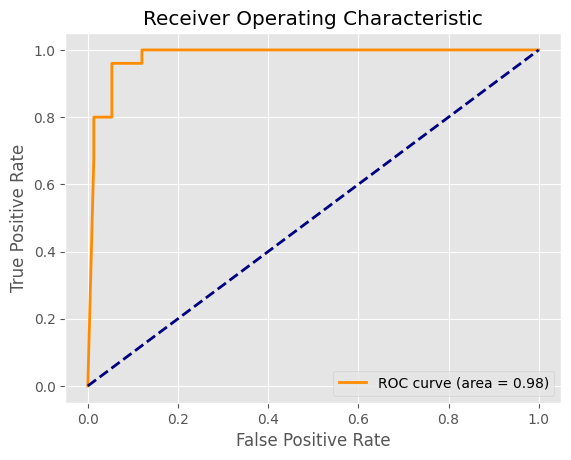

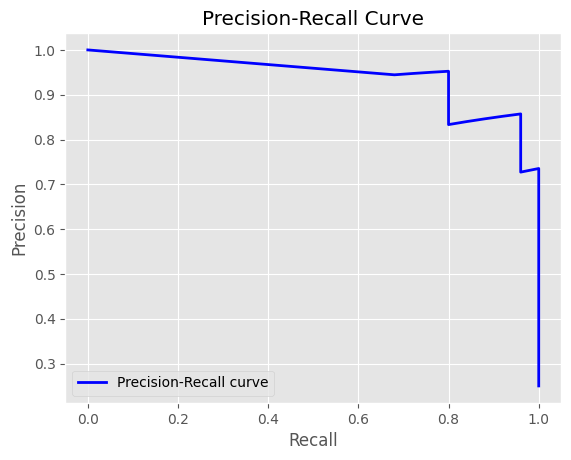

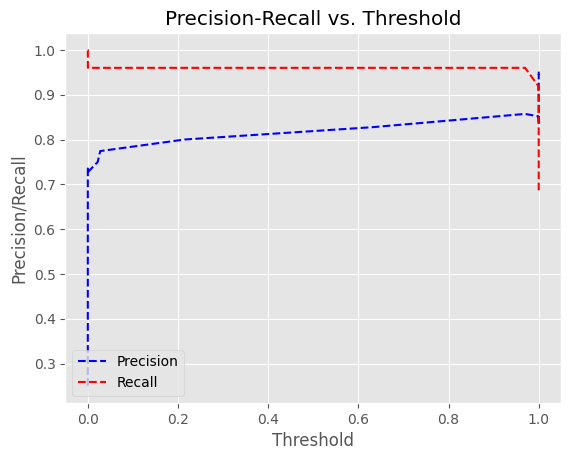

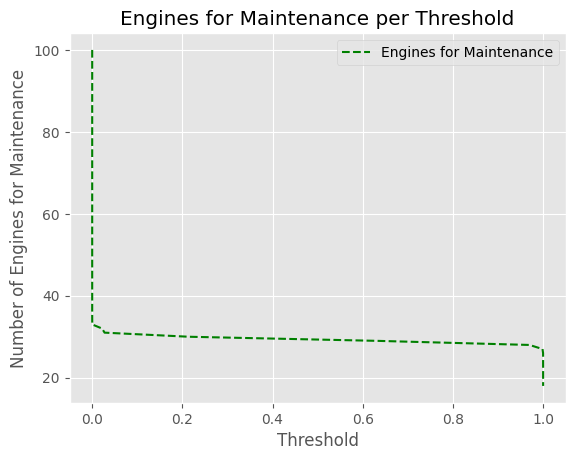

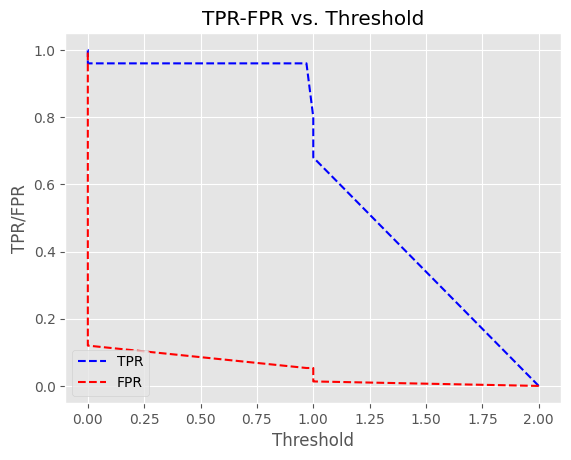

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Calculate probabilities for the positive class
y_scores = Bestparam_gnb.predict_proba(d_test[features])[:, 1]

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Precision-Recall vs. Threshold
plt.figure()
plt.plot(thresholds_pr, precision[:-1], "b--", label="Precision")
plt.plot(thresholds_pr, recall[:-1], "r--", label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall vs. Threshold')
plt.legend(loc="lower left")
plt.show()

# Number of engines predicted for maintenance per period
maintenance_count = [sum(y_scores >= t) for t in thresholds_pr]

plt.figure()
plt.plot(thresholds_pr, maintenance_count, "g--", label="Engines for Maintenance")
plt.xlabel('Threshold')
plt.ylabel('Number of Engines for Maintenance')
plt.title('Engines for Maintenance per Threshold')
plt.legend(loc="upper right")
plt.show()

# TPR-FPR vs. Threshold
plt.figure()
plt.plot(thresholds_roc, tpr, "b--", label="TPR")
plt.plot(thresholds_roc, fpr, "r--", label="FPR")
plt.xlabel('Threshold')
plt.ylabel('TPR/FPR')
plt.title('TPR-FPR vs. Threshold')
plt.legend(loc="lower left")
plt.show()


##**Summary**##

Let's Compare all binary classification algorithms tested based on the metrics.

In [64]:
metrics_lr = {'ROC AUC': roc_auc_lr, 'Recall': recall_lr, 'Accuracy': accuracy_lr, 'Precision': precision_lr, 'F1 Score': f1_lr}
metrics_dt = {'ROC AUC': roc_auc_dt, 'Recall': recall_dt, 'Accuracy': accuracy_dt, 'Precision': precision_dt, 'F1 Score': f1_dt}
metrics_rf = {'ROC AUC': roc_auc_rf, 'Recall': recall_rf, 'Accuracy': accuracy_rf, 'Precision': precision_rf, 'F1 Score': f1_rf}
metrics_svc = {'ROC AUC': roc_auc_svc, 'Recall': recall_svc, 'Accuracy': accuracy_svc, 'Precision': precision_svc, 'F1 Score': f1_svc}
metrics_knn = {'ROC AUC': roc_auc_knn, 'Recall': recall_knn, 'Accuracy': accuracy_knn, 'Precision': precision_knn, 'F1 Score': f1_knn}
metrics_gnb = {'ROC AUC': roc_auc_gnb, 'Recall': recall_gnb, 'Accuracy': accuracy_gnb, 'Precision': precision_gnb, 'F1 Score': f1_gnb}

models_comparison = pd.DataFrame({
    'Logistic Regression': metrics_lr,
    'Decision Tree': metrics_dt,
    'Random Forest': metrics_rf,
    'SVC': metrics_svc,
    'KNN': metrics_knn,
    'Gaussian Naive Bayes': metrics_gnb
})


models_comparison = models_comparison.T

print(models_comparison)

                       ROC AUC  Recall  Accuracy  Precision  F1 Score
Logistic Regression   0.981333    0.72      0.92   0.947368  0.818182
Decision Tree         0.962933    0.72      0.92   0.947368  0.818182
Random Forest         0.983467    0.64      0.90   0.941176  0.761905
SVC                   0.926400    0.72      0.92   0.947368  0.818182
KNN                   0.963467    0.72      0.92   0.947368  0.818182
Gaussian Naive Bayes  0.980533    0.96      0.94   0.827586  0.888889


- Most of the binary classifiers showed better performance metrics with the addition of new features.
- Random Forest, Logistic Regression and Naive Bayes showed same performance before and after feature engineering, still the best but improved a little bit.
-  Linear SVC (with new features) scored better than SVC without new features.
- Linear SVC has totally different scoring metrics before and after adding features.
- Although GNB has the best ROC AUC, it has the lowest precision.
- Logistic Regression is the best classifier.